# Data Augmentation 

Data 

Data augmentation makes a CNN more invariant, which is its ability to classify objects in images that are not perfectly placed in it. If we have a small dataset, data augmentation can serve as a generator of data which in most cases will enforce the predicitve ability of a neural network. Another postive aspect of data augmentation is to prevent over-fitting. 



In [61]:
import PIL
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import time
import os
import copy
import math
print(torch.__version__)
plt.ion()   # interactive mode

1.3.0+cpu


In [62]:

mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

def show_dataset(dataset, n=6):
    img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                     for i in range(len(dataset))))
    plt.imshow(img)
    plt.axis('off')

In [63]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [64]:
data_dir = '../numerical_examples/data'
CHECK_POINT_PATH = '../numerical_examples/models/checkpoint.tar'
SUBMISSION_FILE = '../numerical_examples/data/submission.csv'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

['cats', 'dogs']
Train image size: 23000
Validation image size: 2000


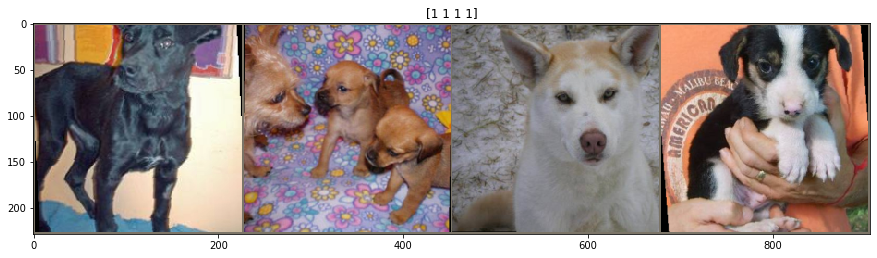

In [65]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
imshow(sample_train_images, title=classes.numpy())

In [66]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=2, checkpoint = None, dataloaders = None):
    since = time.time()
    if dataloaders is None:
        print("no dataloader")
        return
    
    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                if i % 1000 == 999:
                    print('[%d, %d] loss: %.3f' % 
                          (epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [67]:
model_conv = torchvision.models.resnet18(pretrained=True)

In [68]:
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [69]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [70]:
checkpoint = torch.load(CHECK_POINT_PATH)
model_conv.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [32]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint not found
Epoch 0/2
----------


c:\users\moutz\desktop\pythonenv\venv\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1, 199] loss: 0.349
[1, 399] loss: 0.366
[1, 599] loss: 0.374
[1, 799] loss: 0.376
[1, 999] loss: 0.376
[1, 1199] loss: 0.380
[1, 1399] loss: 0.377
[1, 1599] loss: 0.380
[1, 1799] loss: 0.373
[1, 1999] loss: 0.366
[1, 2199] loss: 0.374
[1, 2399] loss: 0.381
[1, 2599] loss: 0.376
[1, 2799] loss: 0.371
[1, 2999] loss: 0.374
[1, 3199] loss: 0.370
[1, 3399] loss: 0.374
[1, 3599] loss: 0.374
[1, 3799] loss: 0.379
[1, 3999] loss: 0.379
[1, 4199] loss: 0.381
[1, 4399] loss: 0.386
[1, 4599] loss: 0.383
[1, 4799] loss: 0.381
[1, 4999] loss: 0.379
[1, 5199] loss: 0.377
[1, 5399] loss: 0.377
[1, 5599] loss: 0.378
train Loss: 0.3777 Acc: 0.8648
[1, 199] loss: 0.227
[1, 399] loss: 0.219
val Loss: 0.2205 Acc: 0.9190
New best model found!
New record loss: 0.2204686402648922, previous record loss: inf
Epoch 1/2
----------
[2, 199] loss: 0.397
[2, 399] loss: 0.445
[2, 599] loss: 0.447
[2, 799] loss: 0.437
[2, 999] loss: 0.428
[2, 1199] loss: 0.420
[2, 1399] loss: 0.414
[2, 1599] loss: 0.417
[2, 1799] 

In [71]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

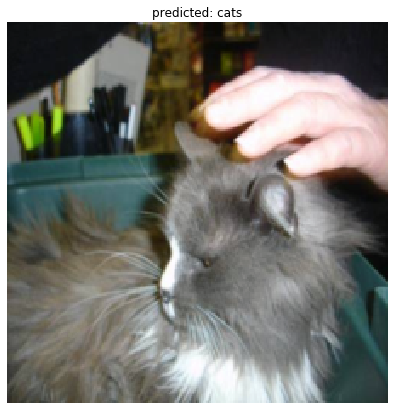

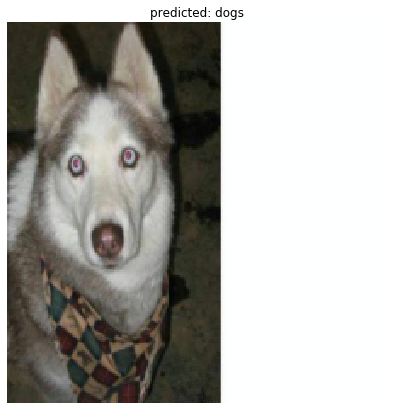

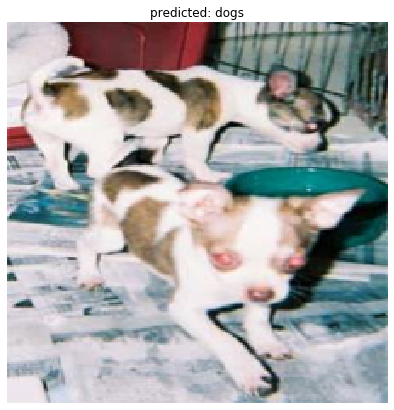

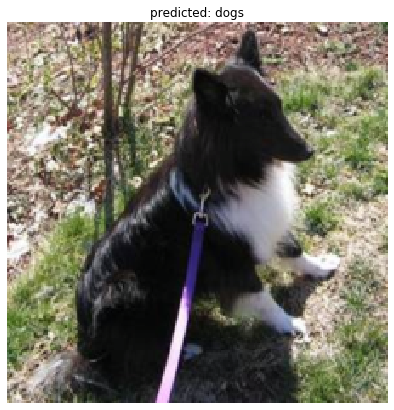

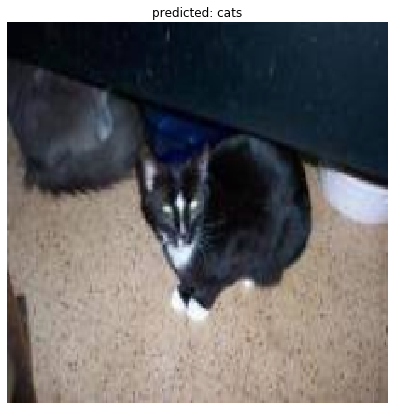

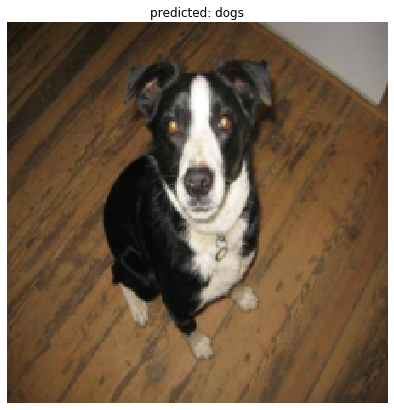

In [72]:

visualize_model(model_conv)

plt.ioff()
plt.show()

In [87]:
preprocess = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])

In [74]:
from PIL import Image

test_data_dir = f'{data_dir}/test'
test_data_files = os.listdir(test_data_dir)

In [75]:
def predict_dog_prob_of_single_instance(model, tensor):
    batch = torch.stack([tensor])
    softMax = nn.Softmax(dim = 1)
    preds = softMax(model(batch))
    return preds[0,1].item()

In [86]:
def test_data_from_fname(fname):
    im = Image.open(f'{test_data_dir}/{fname}')
    return preprocess(im)

In [77]:
def extract_file_id(fname):
    print(fname, end = "\r")
    return int(re.search('\d+', fname).group())

In [88]:
model_conv.eval() # set model to eval mode
id_to_dog_prob = {extract_file_id(fname): 
                  predict_dog_prob_of_single_instance(model_conv, test_data_from_fname(fname))
                  for fname in test_data_files}

In [89]:
import csv
import os
def WriteDictToCSV(csv_file,csv_columns,dict_data):
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in dict_data:
            writer.writerow({'id': data, 'label': dict_data[data]})
    return    


In [90]:
csv_file = "../numerical_examples/data/submission.csv"
csv_columns = ['id','label']
WriteDictToCSV(csv_file,csv_columns,id_to_dog_prob)

The modelled scored $0.11626$ which is around public ranking number $624$ with just $3$ epochs of training.

## No Agumentation

In [20]:
data_transforms_no_aug = {
    'train': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [28]:
data_dir = '../numerical_examples/data'
CHECK_POINT_PATH2 = '../numerical_examples/models/checkpoint_no_aug.tar'
SUBMISSION_FILE = '../numerical_examples/data/submission.csv'
image_datasets_no_aug = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_no_aug[x])
                  for x in ['train', 'val']}
dataloaders_no_aug = {x: torch.utils.data.DataLoader(image_datasets_no_aug[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes_no_aug = {x: len(image_datasets_no_aug[x]) for x in ['train', 'val']}
class_names = image_datasets_no_aug['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes_no_aug["train"]}')
print(f'Validation image size: {dataset_sizes_no_aug["val"]}')

['cats', 'dogs']
Train image size: 23000
Validation image size: 2000


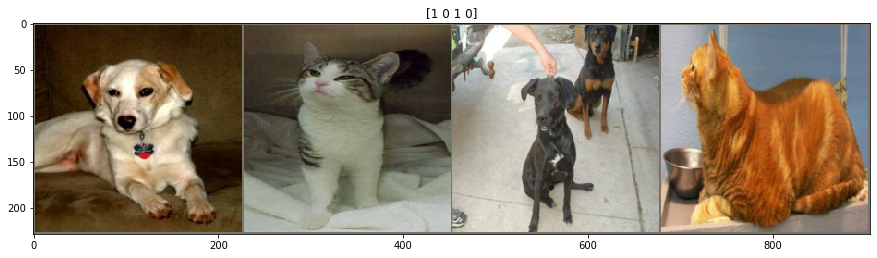

In [29]:
inputs, classes = next(iter(dataloaders_no_aug['train']))
# Make a grid from batch
sample_train_images_no_aug = torchvision.utils.make_grid(inputs)
imshow(sample_train_images_no_aug, title=classes.numpy())

In [30]:
model_conv_no_aug = torchvision.models.resnet18(pretrained=True)

In [31]:
print(model_conv_no_aug)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
for param in model_conv_no_aug.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_no_aug.fc.in_features
model_conv_no_aug.fc = nn.Linear(num_ftrs, 2)

model_conv_no_aug = model_conv_no_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv_no_aug = optim.SGD(model_conv_no_aug.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_no_aug, step_size=7, gamma=0.1)

In [38]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH2)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv_no_aug, best_val_loss, best_val_acc = train_model(model_conv_no_aug,
                                                            criterion,
                                                            optimizer_conv_no_aug,
                                                            exp_lr_scheduler,
                                                            num_epochs = 3,
                                                            checkpoint = checkpoint,
                                                            dataloaders = dataloaders_no_aug)
torch.save({'model_state_dict': model_conv_no_aug.state_dict(),
            'optimizer_state_dict': optimizer_conv_no_aug.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH2)

checkpoint not found
Epoch 0/2
----------
[1, 199] loss: 0.375
[1, 399] loss: 0.399
[1, 599] loss: 0.410
[1, 799] loss: 0.434
[1, 999] loss: 0.431
[1, 1199] loss: 0.420
[1, 1399] loss: 0.408
[1, 1599] loss: 0.402
[1, 1799] loss: 0.397
[1, 1999] loss: 0.404
[1, 2199] loss: 0.397
[1, 2399] loss: 0.398
[1, 2599] loss: 0.408
[1, 2799] loss: 0.399
[1, 2999] loss: 0.394
[1, 3199] loss: 0.396
[1, 3399] loss: 0.400
[1, 3599] loss: 0.400
[1, 3799] loss: 0.400
[1, 3999] loss: 0.407
[1, 4199] loss: 0.403
[1, 4399] loss: 0.406
[1, 4599] loss: 0.411
[1, 4799] loss: 0.407
[1, 4999] loss: 0.405
[1, 5199] loss: 0.407
[1, 5399] loss: 0.408
[1, 5599] loss: 0.407
train Loss: 0.4044 Acc: 0.8599
[1, 199] loss: 0.086
[1, 399] loss: 0.087
val Loss: 0.0920 Acc: 0.9640
New best model found!
New record loss: 0.0919591407828848, previous record loss: inf

Epoch 1/2
----------
[2, 199] loss: 0.405
[2, 399] loss: 0.363
[2, 599] loss: 0.365
[2, 799] loss: 0.352
[2, 999] loss: 0.347
[2, 1199] loss: 0.352
[2, 1399] l

In [91]:
id_to_dog_prob_no_aug = {extract_file_id(fname): 
                  predict_dog_prob_of_single_instance(model_conv_no_aug, test_data_from_fname(fname))
                  for fname in test_data_files}

In [92]:
csv_file = "../numerical_examples/data/submission_no_aug.csv"
csv_columns = ['id','label']
WriteDictToCSV(csv_file,csv_columns,id_to_dog_prob_no_aug)